# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability
*   delayed healing
*   partial paresis
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\].

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2022-09-20 15:07:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34682 (34K) [application/x-httpd-php]
Saving to: ‘diabetes_data_upload.csv.1’

diabetes_data_uploa 100%[===================>]  33.87K   219KB/s    in 0.2s    

2022-09-20 15:08:00 (219 KB/s) - ‘diabetes_data_upload.csv.1’ saved [34682/34682]



In [ ]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [ ]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [ ]:

max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [ ]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


In [ ]:
#Class for the sigmoid activation function
class Sigmoid:
    def __init__(self):
      pass

    #Computes the sigmoid function
    def forward(self, inputs):
      self.output = 1/(1 + np.exp(-inputs))
      return self.output

    #Backpropagates the incoming error using the derivative of sigmoid
    def backward(self, dy):
      return dy*self.output*(1-self.output) # dy/4

In [ ]:
class ReLU:
  def __init__(self):
    pass

  def forward(self, input):
    self.input = input
    ret = input.copy()
    ret[ret<0] = 0
    return ret

  def backward(self, dy):
    dx = dy.copy()
    dx[self.input<0] = 0
    return dx

In [ ]:
#This class describes a fully connected layer (without activation function)

class Linear:
    # W: weight matrix (in x out)
    # b: bias (out x 1)

    #Constructor - we define the parameters of this layer
    def __init__(self, num_inputs, num_outputs, learning_rate, name):
      #The parameters are initialized randomly - uniform distribution [0,1)
      self.W = np.random.rand(num_inputs, num_outputs)
      self.b = np.zeros((num_outputs, 1))
      self.lr = learning_rate
      self.name = name

    # input: mini-batch (batch_size x in)
    # This function only operates the linear function
    def forward(self, input):
      self.inputs = input
      return np.dot(self.inputs, self.W) + self.b.T

    # dy: Error in next layer (batch_size x out)
    # This functions receives the error of the next layer and computes the error in this layer
    def backward(self, dy):
      batch_size = dy.shape[0]
      dy = dy.T # (out x batch_size)
      dw = dy.dot(self.inputs) #(out x in)
      db = np.sum(dy, axis=1, keepdims=True) #(out x 1)
      dx = np.dot(dy.T, self.W.T) # (batch_size x out) x (out x in)

      #SGD Rules
      self.W -= (self.lr/batch_size)*dw.T
      self.b -= (self.lr/batch_size)*db

      #The function computes the error in this layer and returns it for backpropagation
      return dx



# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20.
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [ ]:

#Loss function
def mse(output, labels):
  return 0.5*np.sum((output-labels)**2)
#Class for the neural network
class NetworkReLU:
    def __init__(self,lr): #we pass learningrate as a paremeter
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons

      self.layers = []
      self.layers.append(Linear(num_inputs=16, num_outputs=5, learning_rate=lr, name='fc1')) #10 + 5 = 15
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=5, learning_rate=lr, name='fc2')) #25 + 5 = 30
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=5, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=5, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=1, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)

    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []

      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch
        loss = 0

        #Iterate over each batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          #We need to identify whether a batch is complete or a batch is incomplete because it is the last one
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]

          acc = 0

          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout

        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)

        #Test after one epoch
        loss = 0
        outputs = []

        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]

          acc = 0

          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          loss += mse(output, label)

          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()

        loss /= test_data.shape[0]
        test_loss.append(loss)

        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}'.format(e, epoch, loss, (100*correct)/test_label.shape[0]))

      return dict({'train_loss': train_loss, 'test_loss':test_loss})

    def evaluate(self, data, label, batch_size):
      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]

        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output

        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()

      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]

        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output

        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)

      return np.vstack(output_pred)

In [ ]:
np.random.seed(10)
# def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
net = NetworkReLU(0.01)
history = net.train(X_train, Y_train, 20, 4000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/4000: loss = 0.191910195050515: Test accuracy=61.53846153846154
Epoch 20/4000: loss = 0.1917889584946881: Test accuracy=61.53846153846154
Epoch 40/4000: loss = 0.19158335108086505: Test accuracy=61.53846153846154
Epoch 60/4000: loss = 0.19116058491395108: Test accuracy=61.53846153846154
Epoch 80/4000: loss = 0.1898092523380131: Test accuracy=61.53846153846154
Epoch 100/4000: loss = 0.1679019244130367: Test accuracy=61.53846153846154
Epoch 120/4000: loss = 0.14813216099045134: Test accuracy=73.07692307692308
Epoch 140/4000: loss = 0.14756378271488438: Test accuracy=73.07692307692308
Epoch 160/4000: loss = 0.14701907357188143: Test accuracy=73.07692307692308
Epoch 180/4000: loss = 0.1464828545714843: Test accuracy=73.07692307692308
Epoch 200/4000: loss = 0.14595626357278937: Test accuracy=73.07692307692308
Epoch 220/4000: loss = 0.14544987882905788: Test accuracy=73.07692307692308
Epoch 240/4000: loss = 0.14495799490181718: Test accuracy=73.07692307692308
Epoch 260/4000: loss = 0

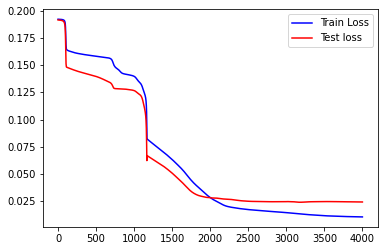

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

##Batch size=1

In [ ]:
np.random.seed(10)
# def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
net = NetworkReLU(0.01)

history_p2_1 = net.train(X_train, Y_train, 1, 500, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/500: loss = 0.19179855774171595: Test accuracy=61.53846153846154
Epoch 20/500: loss = 0.14148188848756635: Test accuracy=73.07692307692308
Epoch 40/500: loss = 0.1284106709053246: Test accuracy=75.0
Epoch 60/500: loss = 0.060081743935837026: Test accuracy=83.65384615384616
Epoch 80/500: loss = 0.040470048290872127: Test accuracy=91.34615384615384
Epoch 100/500: loss = 0.026194868547918363: Test accuracy=94.23076923076923
Epoch 120/500: loss = 0.025665405535854797: Test accuracy=94.23076923076923
Epoch 140/500: loss = 0.02492187340767367: Test accuracy=93.26923076923077
Epoch 160/500: loss = 0.02377307340197245: Test accuracy=93.26923076923077
Epoch 180/500: loss = 0.024157213546714226: Test accuracy=93.26923076923077
Epoch 200/500: loss = 0.024654507073418708: Test accuracy=93.26923076923077
Epoch 220/500: loss = 0.024686054913001874: Test accuracy=93.26923076923077
Epoch 240/500: loss = 0.02221579600713427: Test accuracy=93.26923076923077
Epoch 260/500: loss = 0.02194101633512

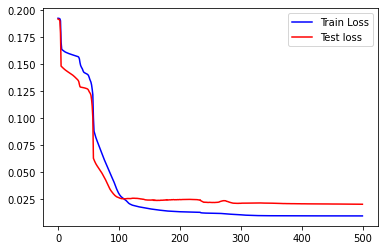

In [ ]:
plt.figure()
plt.plot(history_p2_1['train_loss'], color='b', label='Train Loss')
plt.plot(history_p2_1['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

##Batch-size=415


In [ ]:
np.random.seed(10)
# def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
net = NetworkReLU(0.01)
history_p2_2 = net.train(X_train, Y_train, 415, 60000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/60000: loss = 0.1919146269051444: Test accuracy=61.53846153846154
Epoch 20/60000: loss = 0.1919101710329725: Test accuracy=61.53846153846154
Epoch 40/60000: loss = 0.1919056181345432: Test accuracy=61.53846153846154
Epoch 60/60000: loss = 0.19190096506926813: Test accuracy=61.53846153846154
Epoch 80/60000: loss = 0.1918962085610811: Test accuracy=61.53846153846154
Epoch 100/60000: loss = 0.19189134519110979: Test accuracy=61.53846153846154
Epoch 120/60000: loss = 0.19188637138986875: Test accuracy=61.53846153846154
Epoch 140/60000: loss = 0.1918812834289379: Test accuracy=61.53846153846154
Epoch 160/60000: loss = 0.19187607741208604: Test accuracy=61.53846153846154
Epoch 180/60000: loss = 0.19187074926579617: Test accuracy=61.53846153846154
Epoch 200/60000: loss = 0.19186529472914612: Test accuracy=61.53846153846154
Epoch 220/60000: loss = 0.19185970934299099: Test accuracy=61.53846153846154
Epoch 240/60000: loss = 0.19185398843839285: Test accuracy=61.53846153846154
Epoch 260/

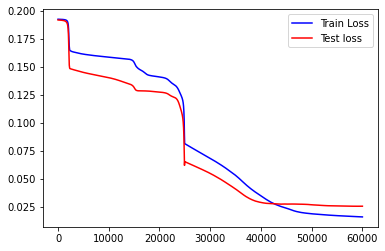

In [ ]:
plt.figure()
plt.plot(history_p2_2['train_loss'], color='b', label='Train Loss')
plt.plot(history_p2_2['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

###Discusión###
Se pueden apreciar diferencias sustanciales en ambos experimentos, para el primer caso en donde el batch-size es de 1 se puede observar un accuracy se 95% en 500 épocas de entrenamiento, mientras que para el caso en que el batch-size=415 a penas se logra un accuracy del 93% pero tomando un total 60000 épocas.La principal explicación de este fenómeno es el numero de veces en que son actualizados los parámetros (Descenso de Gradiente) para cada epoca.Tener un batch-size tamaño 1 garantiza que los parámetros se actualizarán por cada muestra  de entrenamiento (se computa una muestra y se realiza descenso de gradiente, se tendrá un feedback por cada muestra) mientras que un batchsize de tamaño del set genera solamente una actualización (descenso de gradiente ) por cada época, lo cual radica en un aprendizaje más generalizado tomando un mayor numero de épocas para que la red aprenda. Sin embargo el tiempo tomado por en cada época  es significativamente menor para el batch-size más grande debido justamente  a que se realiza sólo un cálculo de los gradiente para cada época.Cabe destacar que a pesar de las diferencas en el numero de iteraciones necesarias para el aprendizaje, la gran ventaja que supone ocupar un batch-size cercano al numero del dataset es que  en cada actualizacion de parametros el gradiente correspondera a uno mas representativo del data set  radicando en un descenso de gradiente "más ordenado" en comparación a un batchsize menor. Por otro lado el tamaño del data set utilizado en este experimento no tiene una gran cantidad de parametros asociados como para evidenciar los beneficios (y limitaciones) asociados al gradiente descendiente estocástico.


# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

##lr=0.5


In [ ]:
np.random.seed(10)
# def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
net = NetworkReLU(0.5)
history_p31 = net.train(X_train, Y_train, 20, 6000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/6000: loss = 0.19146485049005513: Test accuracy=61.53846153846154
Epoch 20/6000: loss = 0.11756757668458785: Test accuracy=75.0
Epoch 40/6000: loss = 0.025715402598563454: Test accuracy=93.26923076923077
Epoch 60/6000: loss = 0.020053046292769165: Test accuracy=95.1923076923077
Epoch 80/6000: loss = 0.019147920040208884: Test accuracy=95.1923076923077
Epoch 100/6000: loss = 0.020918572183618037: Test accuracy=95.1923076923077
Epoch 120/6000: loss = 0.02106428310881756: Test accuracy=95.1923076923077
Epoch 140/6000: loss = 0.021099332655382615: Test accuracy=95.1923076923077
Epoch 160/6000: loss = 0.021106031606001288: Test accuracy=95.1923076923077
Epoch 180/6000: loss = 0.02098922368873914: Test accuracy=95.1923076923077
Epoch 200/6000: loss = 0.02084634628458817: Test accuracy=95.1923076923077
Epoch 220/6000: loss = 0.020613722609713333: Test accuracy=95.1923076923077
Epoch 240/6000: loss = 0.020289498368993634: Test accuracy=95.1923076923077
Epoch 260/6000: loss = 0.01939026

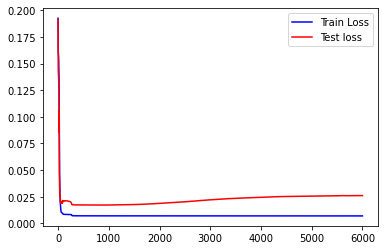

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_p31['train_loss'], color='b', label='Train Loss')
plt.plot(history_p31['test_loss'], color='r', label='Test loss')
plt.legend()
plt.figure()
plt.show()

##lr=0.000001


In [ ]:
np.random.seed(10)
# def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
net = NetworkReLU(0.000001)
history_p32 = net.train(X_train, Y_train, 20, 5000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))

Epoch 0/5000: loss = 0.19191484674610487: Test accuracy=61.53846153846154
Epoch 20/5000: loss = 0.19191483754054472: Test accuracy=61.53846153846154
Epoch 40/5000: loss = 0.19191482833457435: Test accuracy=61.53846153846154
Epoch 60/5000: loss = 0.1919148191281936: Test accuracy=61.53846153846154
Epoch 80/5000: loss = 0.19191480992140264: Test accuracy=61.53846153846154
Epoch 100/5000: loss = 0.1919148007142013: Test accuracy=61.53846153846154
Epoch 120/5000: loss = 0.19191479150658963: Test accuracy=61.53846153846154
Epoch 140/5000: loss = 0.1919147822985676: Test accuracy=61.53846153846154
Epoch 160/5000: loss = 0.19191477309013513: Test accuracy=61.53846153846154
Epoch 180/5000: loss = 0.1919147638812922: Test accuracy=61.53846153846154
Epoch 200/5000: loss = 0.19191475467203883: Test accuracy=61.53846153846154
Epoch 220/5000: loss = 0.19191474546237502: Test accuracy=61.53846153846154
Epoch 240/5000: loss = 0.19191473625230063: Test accuracy=61.53846153846154
Epoch 260/5000: loss =

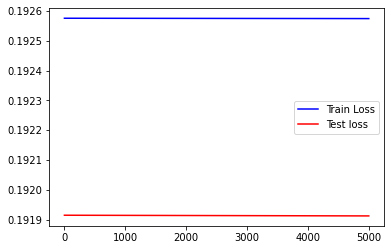

In [ ]:
plt.figure()
plt.plot(history_p32['train_loss'], color='b', label='Train Loss')
plt.plot(history_p32['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

###Discusión###
Se puede apreciar una diferencia sustancial en la cantidad de iteraciones que necesitan ambos experimentos para alcanzar los mínimos.Cuando el learning rate es demasiado pequeño se vuelve muy difícil para la red generar un aprendizaje.Como se puede apreciar en el segundo experimento la'acuracy'  es incapaz de converger a un buen resultado ( en el ejemplo se intenta con 5000 iteraciones , pero incluso con 100000 no se obtiene un mejor resultado) esto debido a que el learning rate es marginal por lo que las actualizaciones de parámetros en cada época radican en un cambio imperceptible.Por otro lado cuando se aumenta el valor del learning rate (lr=0.5) se obtiene de  resultado un 'accuracy' cercana al 93% en 4000 iteraciones.Un aspecto a destacar es que debido a la velocidad del learning rate  es alta , la velocidad en que la red aprende tambien es alta (observar pendiente en el primer experimento) sin embargo,y por esta misma razón, tambien se tiene que la red alterna entre varios mínimos (en principio alcanza un acuracy del 96%).

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [ ]:
#Loss function
def mse(output, labels):
  return 0.5*np.sum((output-labels)**2)
class random_NetworkReLU:
    def __init__(self,lr): #we pass learningrate as a paremeter
      #The layers are in a list
      # We create a three-layer network with sigmoid neurons

      self.layers = []
      self.layers.append(Linear(num_inputs=16, num_outputs=5, learning_rate=lr, name='fc1')) #10 + 5 = 15
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=5, learning_rate=lr, name='fc2')) #25 + 5 = 30     = Cost is a function 51-dimensional space
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=5, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=5, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(ReLU())
      self.layers.append(Linear(num_inputs=5, num_outputs=1, learning_rate=lr, name='fc2')) #5 + 1 = 6
      self.layers.append(Sigmoid())
      self.num_layers = len(self.layers)

    #Implements the training algorithm with mini-batch SGD
    def train(self, training_data, training_label, epoch, test_data, test_label, verbose=False):
      #History values of losses
      train_loss = []
      test_loss = []
      batches=[]

      #Main outer loop
      for e in range(epoch):
        # Perform a training epoch
        loss = 0
        #choose a random size for batches
        batch_size=np.random.randint(1,416)
        batches+=[batch_size]
        #Iterate over each batch
        for batch_index in range(0, training_data.shape[0], batch_size):
          #We need to identify whether a batch is complete or a batch is incomplete because it is the last one
          if batch_index+batch_size < training_data.shape[0]:
            data = training_data[batch_index:batch_index+batch_size]
            label = training_label[batch_index:batch_index+batch_size]
          else:
            data = training_data[batch_index:training_data.shape[0]]
            label = training_label[batch_index:training_label.shape[0]]

          acc = 0

          #Forward pass - iterate over the list of layers
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          #The first error is the derivative of the loss wrt. the NN output
          dy = output - label
          loss += mse(output, label) #Compute the loss

          #Backpropagate
          for l in range(self.num_layers-1, -1, -1):
            dout = self.layers[l].backward(dy)
            dy = dout

        #End of an epoch
        loss /= training_data.shape[0]
        train_loss.append(loss)

        #Test after one epoch
        loss = 0
        outputs = []

        correct = 0
        for batch_index in range(0, test_data.shape[0], batch_size):
          if batch_index+batch_size < test_data.shape[0]:
            data = test_data[batch_index:batch_index+batch_size]
            label = test_label[batch_index:batch_index+batch_size]
          else:
            data = test_data[batch_index:test_data.shape[0]]
            label = test_label[batch_index:test_label.shape[0]]

          acc = 0

          #Forward pass
          x = data
          for l in range(self.num_layers):
            output = self.layers[l].forward(x)
            x = output

          loss += mse(output, label)

          test_output = (output >= 0.5)
          #Compare the output of the network with the correct labels
          correct += (test_output == label).sum()

        loss /= test_data.shape[0]
        test_loss.append(loss)

        if verbose:
          print('Epoch {}/{}: loss = {}: Test accuracy={}  batch size: {}'.format(e, epoch, loss, (100*correct)/test_label.shape[0],batch_size))
        else:
          if e % 20 == 0:
            print('Epoch {}/{}: loss = {}: Test accuracy={}  batch size: {}'.format(e, epoch, loss, (100*correct)/test_label.shape[0],batch_size))

      return dict({'train_loss': train_loss, 'test_loss':test_loss,'batches':batches})

    def evaluate(self, data, label, batch_size):
      correct = 0
      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
          nlabel = label[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]
          nlabel = label[batch_index:label.shape[0]]

        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output

        test_output = (output >= 0.5)
        #Compare the output of the network with the correct labels
        correct += (test_output == nlabel).sum()

      return (100*correct)/label.shape[0]

    def predict(self, data, batch_size):
      output_pred = []

      for batch_index in range(0, data.shape[0], batch_size):
        if batch_index+batch_size < data.shape[0]:
          ndata = data[batch_index:batch_index+batch_size]
        else:
          ndata = data[batch_index:data.shape[0]]

        x = ndata
        for l in range(self.num_layers):
          output = self.layers[l].forward(x)
          x = output

        test_output = (output >= 0.5)
        #test_output = np.argmax(output, axis=1)
        output_pred.append(test_output)

      return np.vstack(output_pred)

In [ ]:
np.random.seed(10)
# def train(self, training_data, training_label, batch_size, epoch, test_data, test_label, verbose=False):
net = random_NetworkReLU(0.01)
history_p4= net.train(X_train, Y_train, 7000, X_test, Y_test)

print('Train accuracy:{} - Test accuracy: {}'.format(net.evaluate(X_train, Y_train, 20), net.evaluate(X_test, Y_test, 20)))


Epoch 0/7000: loss = 0.19191443251106344: Test accuracy=61.53846153846154  batch size: 332
Epoch 20/7000: loss = 0.19187042680487165: Test accuracy=61.53846153846154  batch size: 52
Epoch 40/7000: loss = 0.19183463549545277: Test accuracy=61.53846153846154  batch size: 42
Epoch 60/7000: loss = 0.1916248688606208: Test accuracy=61.53846153846154  batch size: 208
Epoch 80/7000: loss = 0.1915486326020725: Test accuracy=61.53846153846154  batch size: 349
Epoch 100/7000: loss = 0.19130379712953596: Test accuracy=61.53846153846154  batch size: 64
Epoch 120/7000: loss = 0.19122993644421682: Test accuracy=61.53846153846154  batch size: 314
Epoch 140/7000: loss = 0.19111692788227724: Test accuracy=61.53846153846154  batch size: 302
Epoch 160/7000: loss = 0.19099719587633426: Test accuracy=61.53846153846154  batch size: 249
Epoch 180/7000: loss = 0.19060162390076968: Test accuracy=61.53846153846154  batch size: 27
Epoch 200/7000: loss = 0.1897508348823391: Test accuracy=61.53846153846154  batch 

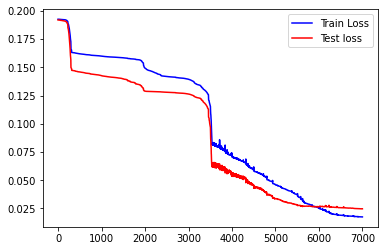

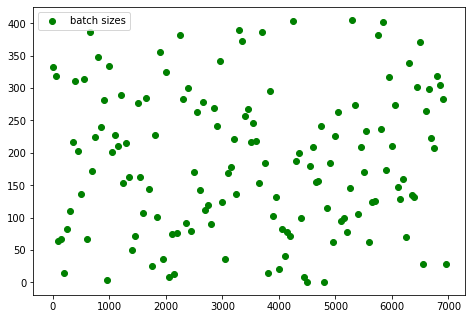

In [ ]:
plt.figure()
plt.plot(history_p4['train_loss'], color='b', label='Train Loss')
plt.plot(history_p4['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter([i for i in range(0,len(history_p4['batches']),50)],[history_p4['batches'][i] for i in range(0,len(history_p4['batches']),50)], color='g', label='batch sizes')
plt.legend()
plt.show()



## Comparar con P1
-Batch size constante=20


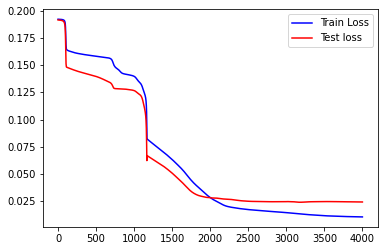

In [ ]:
plt.figure()
plt.plot(history['train_loss'], color='b', label='Train Loss')
plt.plot(history['test_loss'], color='r', label='Test loss')
plt.legend()
plt.show()

###Discusión###
Al utilizar batch-sizes aleatorios se obtiene un accuracy de aproximadamente 94%  el  cual se estabiliza  al rededor de las 6000 epocas.La  explicación de porqué demora más tiempo en estabilizarse en un mínimo (en comparación a lo realizado en la P1) es similar a lo ocurrido en la parte 2.Un Batch size mayor (Observar en el grafico el tamaño de los batch sizes, en general > 20 )  va a tener un menor número de actualizaciones de parametros por cada iteracion  en comparación a un batchsize menor (p1,batch size=20).Sin embargo una ventaja de implementar un batchsize aleatorio es que  cada batch corresponderá a una muestra mas representativa del total de los datos por lo cual ,al momento de  el calculo del gradiente  y la actualizacion de los parámteros  el descenso de gradiente sera más dirigido a una solución general  que lo que se puede extraer de un conjunto de datos locales.Por otra parte el uso de batch sizes aleatorios genera pequeños saltos dentro del aprendizaje de la red (observar desde la iteracion 3000), este ruido puede facilitar el aprendizaje en el sentido que es más facil escapar de mínimos locales.